# VDC Autoencoder

In [21]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
import random
%matplotlib inline

## Prepare the dataset

In [2]:
IMG_SIZE = (224, 224)

In [4]:
data_folder = '/home/data_pj_flores/XImages'
images_list = [os.path.join(data_folder, x) for x in os.listdir(data_folder)]
print('Found {} images'.format(len(images_list)))

Found 29988 images


In [5]:
images_list[:10]

['/home/data_pj_flores/XImages/IMG_5633.jpg',
 '/home/data_pj_flores/XImages/IMG_23213.jpg',
 '/home/data_pj_flores/XImages/IMG_11038.jpg',
 '/home/data_pj_flores/XImages/IMG_97.jpg',
 '/home/data_pj_flores/XImages/IMG_11711.jpg',
 '/home/data_pj_flores/XImages/IMG_7542.jpg',
 '/home/data_pj_flores/XImages/IMG_808.jpg',
 '/home/data_pj_flores/XImages/IMG_3555.jpg',
 '/home/data_pj_flores/XImages/IMG_13085.jpg',
 '/home/data_pj_flores/XImages/IMG_1816.jpg']

In [6]:
train_images, test_images = train_test_split(images_list, test_size=0.2)
print('Train images: {}'.format(len(train_images)))
print('Test images: {}'.format(len(test_images)))

Train images: 23990
Test images: 5998


In [7]:
def map_image(image_path):
    rgb = tf.io.read_file(image_path)
    rgb = tf.image.decode_jpeg(rgb, channels=3)
    rgb = tf.image.resize(rgb, IMG_SIZE)
    rgb = tf.cast(rgb, dtype=tf.float32)
    rgb = rgb / 255.0
    return rgb, rgb

In [8]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1024

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).map(map_image)
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).repeat()

test_dataset = tf.data.Dataset.from_tensor_slices(test_images).map(map_image)
test_dataset = test_dataset.batch(BATCH_SIZE).repeat()

## Define the model

In [9]:
# def encoder(inputs, layer_filters, kernel_size, latent_dim):
#     x = inputs
#     for filters in layer_filters:
#         x = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=2, activation='relu', padding='same')(x)
#         x = tf.keras.layers.BatchNormalization()(x)

#     shape = tf.keras.backend.int_shape(x)
#     x = tf.keras.layers.Flatten()(x)
#     x = tf.keras.layers.Dense(latent_dim)(x)
#     return x, shape

In [10]:
def encoder(inputs, layer_filters, kernel_size, latent_dim):
    x = inputs
    for filters in layer_filters:
        x = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=2, activation='relu', padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)

    shape = tf.keras.backend.int_shape(x)
    x = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same', name='output_encoder')(x)
    encoder_visualization = tf.keras.layers.Conv2D(1, 3, activation='sigmoid', padding='same')(x)
    return x, shape, encoder_visualization

In [11]:
# def decoder(inputs, shape, latent_dim, channels):
#     x = tf.keras.layers.Dense(shape[1] * shape[2] * shape[3])(inputs)
#     x = tf.keras.layers.Reshape((shape[1], shape[2], shape[3]))(x)
    
#     for filters in layer_filters[::-1]:
#         x = tf.keras.layers.Conv2DTranspose(filters=filters, kernel_size=kernel_size, strides=2, activation='relu', padding='same')(x)
#         x = tf.keras.layers.BatchNormalization()(x)

#     x = tf.keras.layers.Conv2DTranspose(filters=channels, kernel_size=kernel_size, activation='sigmoid', padding='same')(x)
#     return x

In [12]:
def decoder(inputs, shape, latent_dim, channels):
    x = inputs
    for filters in layer_filters[::-1]:
        x = tf.keras.layers.Conv2DTranspose(filters=filters, kernel_size=kernel_size, strides=2, activation='relu', padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Conv2DTranspose(filters=channels, kernel_size=kernel_size, activation='sigmoid', padding='same')(x)
    return x

In [13]:
def convolutional_autoencoder(input_shape, layer_filters, kernel_size, latent_dim, channels):
    inputs = tf.keras.layers.Input(shape=input_shape)
    encoder_output, shape, encoder_visualization = encoder(inputs, layer_filters, kernel_size, latent_dim)
    decoder_output = decoder(encoder_output, shape, latent_dim, channels)
    
    encoder_model_viz = tf.keras.Model(inputs=inputs, outputs=encoder_visualization)
    autoencoder_model = tf.keras.Model(inputs=inputs, outputs=decoder_output)
    return autoencoder_model, encoder_model_viz

In [14]:
input_shape = (*IMG_SIZE, 3)
kernel_size = 3
latent_dim = 256
output_channels = 3
layer_filters = [32, 64, 128]

autoencoder_model, encoder_viz = convolutional_autoencoder(input_shape, layer_filters, kernel_size, latent_dim, output_channels)
autoencoder_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 112, 112, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 56, 56, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 128)       512 

In [15]:
autoencoder_model.compile(optimizer=tf.keras.optimizers.Adam(), 
                            loss='mean_squared_error')

## Train the model

In [16]:
train_steps = len(train_images) // BATCH_SIZE
valid_steps = len(test_images) // BATCH_SIZE

history = autoencoder_model.fit(train_dataset, steps_per_epoch=train_steps, 
                                validation_data=test_dataset, validation_steps=valid_steps, 
                                epochs=3)

Epoch 1/10
749/749 [==============================] - 263s 351ms/step - loss: 0.0050 - val_loss: 0.0016
Epoch 2/10
749/749 [==============================] - 237s 316ms/step - loss: 0.0013 - val_loss: 9.4853e-04
Epoch 3/10
749/749 [==============================] - 237s 316ms/step - loss: 0.0011 - val_loss: 7.4658e-04
Epoch 4/10
749/749 [==============================] - 237s 316ms/step - loss: 8.9695e-04 - val_loss: 5.2708e-04
Epoch 5/10
 18/749 [..............................] - ETA: 3:37 - loss: 0.0012

KeyboardInterrupt: 

## Get encoder and decoder models

In [17]:
encoder_model = tf.keras.Model(inputs=autoencoder_model.input, 
                               outputs=autoencoder_model.get_layer('output_encoder').output)
encoder_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 112, 112, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 56, 56, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 128)       512 

In [18]:
encoder_viz.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 112, 112, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 56, 56, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 128)       512   

## Display sample

In [19]:
def display_one_row(disp_images, offset, encoded=False):
    for idx, test_image in enumerate(disp_images):
        plt.subplot(3, 10, offset + idx + 1)
        plt.xticks([])
        plt.yticks([])
        if encoded:
            plt.imshow(test_image, cmap='gray')
        else:
            plt.imshow(test_image)


def display_results(disp_input_images, disp_encoded, disp_predicted, enc_shape=(8,4)):
    plt.figure(figsize=(20, 10))
    display_one_row(disp_input_images, 0)
    display_one_row(disp_encoded, 10, encoded=True)
    display_one_row(disp_predicted, 20)

In [45]:
test_data = np.array(next(iter(test_dataset))[0])
idxs = np.random.randint(BATCH_SIZE, size=10)
output_samples = test_data[idxs]
print(output_samples.shape)

(10, 224, 224, 3)


In [46]:
predicted = autoencoder_model.predict(output_samples)
encoded = encoder_model.predict(output_samples)
encoded_viz = encoder_viz.predict(output_samples)

In [47]:
print(predicted.shape)
print(encoded.shape)
print(encoded_viz.shape)

(10, 224, 224, 3)
(10, 28, 28, 256)
(10, 28, 28, 1)


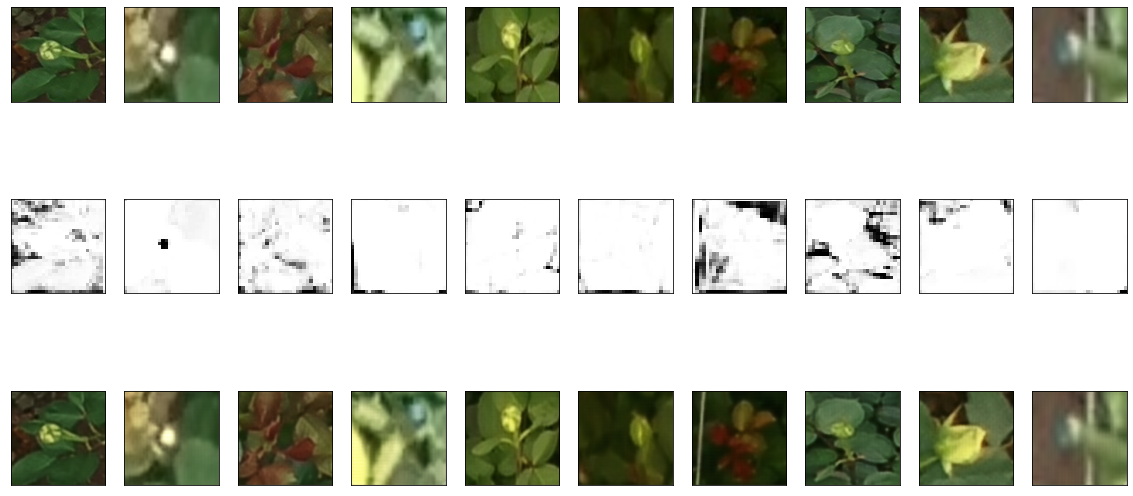

In [48]:
display_results(np.array(output_samples), encoded_viz, predicted)